In [7]:
# xgboost 모델링

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# 1. 전처리된 데이터 로드
X_train = pd.read_csv('processed_data/X_train.csv')
X_test = pd.read_csv('processed_data/X_test.csv')
y_train = pd.read_csv('processed_data/y_train.csv')
y_test = pd.read_csv('processed_data/y_test.csv')

# Series로 변환 (y는 1차원이어야 함)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")

print(f"\n   Train 불량 비율: {(y_train==1).sum() / len(y_train) * 100:.2f}%")
print(f"   Test 불량 비율: {(y_test==1).sum() / len(y_test) * 100:.2f}%")

   X_train: (1253, 478)
   X_test: (314, 478)
   y_train: (1253,)
   y_test: (314,)

   Train 불량 비율: 6.62%
   Test 불량 비율: 6.69%


In [8]:
# 2. 모델 학습

# 불균형 비율 계산
n_positive = (y_train == 1).sum()
n_negative = (y_train == 0).sum()
scale_pos_weight = n_negative / n_positive

# 모델 생성
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight= scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# 모델 학습
import time
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"\n모델 학습 시간: {training_time:.2f} seconds")

# 예측
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]


모델 학습 시간: 1.11 seconds


In [13]:
# 3. 임계값 최적화

thresholds = [0.03, 0.04, 0.05, 0.08, 0.1]
results = []

for thresh in thresholds:
    y_pred = (y_test_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'threshold': thresh,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"\n임계값 {thresh:.2f}:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-score:  {f1:.4f}")

# 최적 임계값 선택 (F1 차이 0.05 미만이면 Recall 우선)
results_df = pd.DataFrame(results)

# F1 최대값 찾기
max_f1 = results_df['f1'].max()

# F1이 최대값과 0.05 차이 이내인 후보들
candidates = results_df[results_df['f1'] >= max_f1 - 0.05]

# 후보들 중 Recall이 가장 높은 것 선택
best_idx = candidates['recall'].idxmax()
best_threshold = results_df.loc[best_idx, 'threshold']

print(f"\n최적 임계값 선택 기준:")
print(f"   F1 최대값: {max_f1:.4f}")
print(f"   F1 차이 0.05 이내 후보: {len(candidates)}개")
print(f"   → Recall 최대화 기준으로 {best_threshold:.2f} 선택")

# 최적 임계값으로 최종 예측
y_train_pred = (y_train_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)


임계값 0.03:
   Accuracy:  0.8217
   Precision: 0.1569
   Recall:    0.3810
   F1-score:  0.2222

임계값 0.04:
   Accuracy:  0.8471
   Precision: 0.1860
   Recall:    0.3810
   F1-score:  0.2500

임계값 0.05:
   Accuracy:  0.8631
   Precision: 0.1944
   Recall:    0.3333
   F1-score:  0.2456

임계값 0.08:
   Accuracy:  0.8981
   Precision: 0.2609
   Recall:    0.2857
   F1-score:  0.2727

임계값 0.10:
   Accuracy:  0.9172
   Precision: 0.3333
   Recall:    0.2381
   F1-score:  0.2778

최적 임계값 선택 기준:
   F1 최대값: 0.2778
   F1 차이 0.05 이내 후보: 4개
   → Recall 최대화 기준으로 0.04 선택


Train 데이터 평가:
   정확도: 0.9992
   정밀도: 0.9881
   재현율: 1.0000
   F1 점수: 0.9940
Test 데이터 평가:
   정확도: 0.8471
   정밀도: 0.1860
   재현율: 0.3810
   F1 점수: 0.2500

Confusion Matrix:
TN: 258
FP: 35
FN: 13
TP: 8


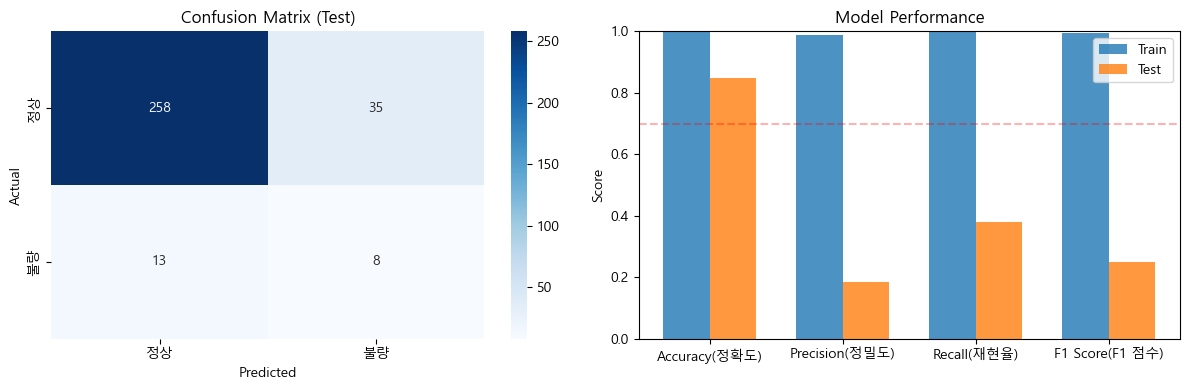

In [14]:
# 4. 모델 평가

# Train 데이터 평가
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f'Train 데이터 평가:')
print(f"   정확도: {train_accuracy:.4f}")
print(f"   정밀도: {train_precision:.4f}")
print(f"   재현율: {train_recall:.4f}")
print(f"   F1 점수: {train_f1:.4f}")

# Test 데이터 평가
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f'Test 데이터 평가:')
print(f"   정확도: {test_accuracy:.4f}")
print(f"   정밀도: {test_precision:.4f}")
print(f"   재현율: {test_recall:.4f}")
print(f"   F1 점수: {test_f1:.4f}")

# Confusion Matrix(혼동 행렬)
cm=confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(f'TN: {cm[0,0]}') # 정상을 정상으로
print(f'FP: {cm[0,1]}') # 정상을 불량으로 - 문제
print(f'FN: {cm[1,0]}') # 불량을 정상으로 - 문제
print(f'TP: {cm[1,1]}') # 불량을 불량으로

# 시각화
plt.rc('font', family='Malgun Gothic')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Test)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['정상', '불량'])
axes[0].set_yticklabels(['정상', '불량'])

# 성능비교 막대 그래프
metrics = ['Accuracy(정확도)', 'Precision(정밀도)', 'Recall(재현율)', 'F1 Score(F1 점수)']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, train_scores, width, label='Train', alpha=0.8)
axes[1].bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
axes[1].set_ylabel('Score')
axes[1].set_title('Model Performance')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].axhline(y=0.7, color='r', linestyle='--', alpha=0.3, label='Target: 0.7')

plt.tight_layout()
plt.show()

In [16]:
# 5. 결과 저장
import pickle

results_xgb = {
    'model_name': 'XGBoost',
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'confusion_matrix': cm
}

with open('../processed_data/results_xgb.pkl', 'wb') as f:
    pickle.dump(results_xgb, f)

print("\n결과 저장 완료: results_xgb.pkl")


결과 저장 완료: results_xgb.pkl


# XGBoost 결과 요약

## 성능
- **Test Accuracy**: 84.71%
- **Test Precision**: 18.60%
- **Test Recall**: 38.10%
- **Test F1-score**: 25.00%

## Random Forest와 비교
| 지표 | Random Forest | XGBoost | 차이 |
|------|---------------|---------|------|
| Test Recall | 57.14% | 38.10% | **-19.04%p** |
| TP (찾은 불량) | 12개 | 8개 | **-4개** |
| FN (놓친 불량) | 9개 | 13개 | **+4개** |
| F1-score | 35.82% | 25.00% | -10.82%p |

## 주요 발견

### 한계점
- RF보다 낮은 성능 (Recall 57% → 38%)
- 과적합 문제 (Train 99.92%, Test 84.71%)
- 샘플 수(1,567) 대비 특성(594) 많아 순차 학습 불리

### 임계값 선택 근거
- F1 최대값과 0.05 이내 후보 중 Recall 우선
- **0.04**: Recall 38.10%, Precision 18.60% 